# 1. Lendo os dados e filtrando eles

In [1]:
import pandas as pd

path = 'data/processed/df_avisos_completos.csv'
df = pd.read_csv(path)

print(df.shape)
df.head()

(50259, 4)


,id_aviso,data_hora,teor_texto,setor_destino
0,18612632.0,2024-06-21 05:00:40,PODER JUDICIÁRIO ESTADO DO RIO GRANDE DO NORTE...,Procuradoria da Saúde
1,18629258.0,2024-06-25 23:59:59,PODER JUDICIÁRIO DO ESTADO DO RIO GRANDE DO NO...,Procuradoria Administrativa
2,18629422.0,2024-06-18 09:27:16,PODER JUDICIÁRIO DO ESTADO DO RIO GRANDE DO NO...,Cartorio
3,18629665.0,2024-07-30 23:59:59,PODER JUDICIÁRIO DO ESTADO DO RIO GRANDE DO NO...,Apoio Fiscal
4,18629671.0,2024-06-18 05:01:05,PODER JUDICIÁRIO DO ESTADO DO RIO GRANDE DO NO...,Procuradoria Fiscal


In [2]:
# Mudando o tipo da coluna data_hora

df['data_hora'] = pd.to_datetime(df['data_hora'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50259 entries, 0 to 50258
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id_aviso       50259 non-null  float64       
 1   data_hora      50259 non-null  datetime64[ns]
 2   teor_texto     50259 non-null  object        
 3   setor_destino  50259 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 1.5+ MB


In [3]:
contagem = df['setor_destino'].value_counts().reset_index()
contagem.columns = ['setor_destino', 'contagem']

total = contagem['contagem'].sum()
contagem['porcetagem'] = (contagem['contagem'] / total * 100).round(2)

contagem['porcetagem_acumulada'] = contagem['porcetagem'].cumsum().round(2)

contagem

,setor_destino,contagem,porcetagem,porcetagem_acumulada
0,Procuradoria Administrativa,16106,32.05,32.05
1,Apoio Fiscal,14396,28.64,60.69
2,Procuradoria Fiscal,6720,13.37,74.06
3,Procuradoria Judicial,3475,6.91,80.97
4,Departamento de Cálculos e Contabilidade,3323,6.61,87.58
5,Procuradoria da Saúde,1849,3.68,91.26
6,Chefia Administrativa,1574,3.13,94.39
7,Chefia Judicial,1242,2.47,96.86
8,Requisitório de Pagamento - Contabilidade,660,1.31,98.17
9,Chefia Meio Ambiente,346,0.69,98.86


# 2. Analisando tipos de peças

Procurando no cabeçalho do texto termos como 'ATO ORDINATÓRIO', 'DESPACHO', 'CERTIDÃO', 'DECISÃO', 'SENTENÇA', 'INTIMAÇÃO'.

In [4]:
import re

patterns = [
    'CUMPRIMENTO DE SENTENÇA', # Padrão para se ignorar (estava dando muito falso positivo em SENTENÇA)
    'ATOORDINATÓRIO',
    'DESPACHO',
    'CERTIDÃO',
    'DECISÃO',
    'SENTENÇA',
    'INTIMAÇÃO',
]

def compile_patterns(patterns):
    compiled = []
    for label in patterns:
        regex = r'\b' + r'\s*'.join(list(label)) + r'\b'
        compiled.append((label, re.compile(regex, flags=re.IGNORECASE)))
    return compiled

compiled_patterns = compile_patterns(patterns)

def apply_regex(text):    
    if not isinstance(text, str):
        return []
    
    results = []
    for label, pattern in compiled_patterns:
        match_obj = pattern.search(text)
        if match_obj:
            results.append((label, match_obj.start()))
    
    if not results:
        return 'Não identificado'

    results.sort(key=lambda x: x[1])

    # Verifica regra para ignorar "CUPRIMENTO DE SENTENÇA"
    if results[0][0] == 'CUMPRIMENTO DE SENTENÇA':
        if len(results) >= 3:
            return results[2][0] # Retornando o 3º match (ignorando CUMPRIMENTO DE SENTENÇA e SENTENÇA)
        else:
            return results[1][0] # Retornando o 2º match (SENTENÇA)
    else:
        return results[0][0]

df['tipo_aviso'] = df['teor_texto'].apply(apply_regex)

In [5]:
df['tipo_aviso'].value_counts()

tipo_aviso
DESPACHO            14594
ATOORDINATÓRIO      13198
DECISÃO              9802
SENTENÇA             9001
Não identificado     2138
CERTIDÃO             1396
INTIMAÇÃO             130
Name: count, dtype: int64

In [6]:
tabela = pd.crosstab(df['tipo_aviso'], df['setor_destino'], margins=True, margins_name="Total").T

tabela.sort_values(by='Total', ascending=False).drop('Total', axis=0)

tipo_aviso,ATOORDINATÓRIO,CERTIDÃO,DECISÃO,DESPACHO,INTIMAÇÃO,Não identificado,SENTENÇA,Total
setor_destino,,,,,,,,
Procuradoria Administrativa,1065,219,3397,5513,54,854,5004,16106
Apoio Fiscal,8020,988,2088,2848,8,218,226,14396
Procuradoria Fiscal,974,75,2108,1758,23,561,1221,6720
Procuradoria Judicial,371,36,765,1223,22,93,965,3475
Departamento de Cálculos e Contabilidade,1969,13,19,1257,0,36,29,3323
Procuradoria da Saúde,63,13,654,590,4,65,460,1849
Chefia Administrativa,113,27,330,467,8,125,504,1574
Chefia Judicial,129,13,272,384,6,112,326,1242
Requisitório de Pagamento - Contabilidade,438,5,0,212,0,4,1,660


In [7]:
# Cria coluna com tamanho do texto
df['tamanho_texto'] = df['teor_texto'].apply(lambda x: len(x.split()))

# Calcular estatistícas por tipo_aviso
estatisticas = (
    df
    .groupby('tipo_aviso')['tamanho_texto']
    .agg([
        ('media', 'mean'),
        ('desvio_padrao', 'std'),
        ('q1', lambda s: s.quantile(0.25)),
        ('mediana', 'median'),
        ('q3', lambda s: s.quantile(0.75)),
        ('minimo', 'min'),
        ('maximo', 'max'),
        ('contagem', 'count')
    ])
    .reset_index()
)

estatisticas

,tipo_aviso,media,desvio_padrao,q1,mediana,q3,minimo,maximo,contagem
0,ATOORDINATÓRIO,111.927868,36.533185,90.0,96.0,131.00,13,824,13198
1,CERTIDÃO,183.839542,297.650826,110.0,116.0,131.00,15,3610,1396
2,DECISÃO,763.056213,833.647816,294.0,558.0,811.00,59,13236,9802
3,DESPACHO,248.624709,168.172374,120.0,251.0,313.00,24,5178,14594
4,INTIMAÇÃO,853.569231,1112.123640,280.0,396.5,1153.75,10,7845,130
5,Não identificado,90.075772,97.856459,90.0,91.0,93.00,1,2115,2138
6,SENTENÇA,1538.688368,1093.824630,741.0,1384.0,2076.00,48,17927,9001


# 2. Separação de Treinamento/Teste/OOT

Para a criação do classificador será considerado 8 classes que compreendem 96.86% do Dataset Original

In [10]:
classes = [
    'Procuradoria Administrativa',
    'Apoio Fiscal',
    'Procuradoria Fiscal',
    'Procuradoria Judicial',
    'Departamento de Cálculos e Contabilidade',
    'Procuradoria da Saúde',
    'Chefia Administrativa',
    'Chefia Judicial'
]


df_filtrado = df[df['setor_destino'].isin(classes)].copy()

# Atualizando o Dataset

# Juntando classes como:
# * Chefia Adminsitrativa + Procuradoria Administrativa
# * Chefia Judicial + Procuradoria Judicial

swap_dict = {
    'Chefia Administrativa': 'Procuradoria Administrativa',
    'Chefia Judicial': 'Procuradoria Judicial'
}

# Substituindo valores acima
df_filtrado.replace(swap_dict, inplace=True)

print(df_filtrado.shape)
df_filtrado.head()

(48685, 6)


,id_aviso,data_hora,teor_texto,setor_destino,tipo_aviso,tamanho_texto
0,18612632.0,2024-06-21 05:00:40,PODER JUDICIÁRIO ESTADO DO RIO GRANDE DO NORTE...,Procuradoria da Saúde,DESPACHO,140
1,18629258.0,2024-06-25 23:59:59,PODER JUDICIÁRIO DO ESTADO DO RIO GRANDE DO NO...,Procuradoria Administrativa,DESPACHO,120
3,18629665.0,2024-07-30 23:59:59,PODER JUDICIÁRIO DO ESTADO DO RIO GRANDE DO NO...,Apoio Fiscal,DESPACHO,95
4,18629671.0,2024-06-18 05:01:05,PODER JUDICIÁRIO DO ESTADO DO RIO GRANDE DO NO...,Procuradoria Fiscal,DESPACHO,167
5,18629724.0,2024-07-02 23:59:59,PODER JUDICIÁRIO DO ESTADO DO RIO GRANDE DO NO...,Procuradoria Administrativa,DECISÃO,795


## 2.1 - OTT

* O OTT (Out of Time) é uma porção do dataset que será utilizado para a validação temporal do modelo criado.
* A diferença do OTT e Teste é que o OTT possui caracteristica temporal ordenando o dataset por data e separando uma porcentagem do fim do dataset.
* Isso serve como um extrato das demandas de um determinado periodo.

In [13]:
df_filtrado_sorted = df_filtrado.sort_values(by='data_hora', ascending=True)
df_filtrado_sorted.tail()

,id_aviso,data_hora,teor_texto,setor_destino,tipo_aviso,tamanho_texto
49769,23207993.0,2025-05-19 13:25:30,Poder Judiciário do Estado do Rio Grande do No...,Procuradoria Administrativa,DECISÃO,567
49790,23208597.0,2025-05-19 13:27:59,PODER JUDICIÁRIO DO ESTADO DO RIO GRANDE DO NO...,Procuradoria Judicial,DECISÃO,208
49779,23208282.0,2025-05-19 13:28:24,Poder Judiciário do Estado do Rio Grande do No...,Procuradoria Administrativa,DESPACHO,54
49791,23208601.0,2025-05-19 13:29:02,PODER JUDICIÁRIO DO ESTADO DO RIO GRANDE DO NO...,Procuradoria Judicial,DECISÃO,215
50047,23220203.0,2025-05-20 08:50:46,PODER JUDICIÁRIO DO ESTADO DO RIO GRANDE DO NO...,Apoio Fiscal,DESPACHO,120


In [14]:
# Índice de corte
idx_corte = int(len(df_filtrado) * 0.9)

# Split
df_train_test = df_filtrado_sorted.iloc[:idx_corte].copy()
df_oot = df_filtrado_sorted.iloc[idx_corte:].copy()


In [15]:
df_oot

,id_aviso,data_hora,teor_texto,setor_destino,tipo_aviso,tamanho_texto
44951,22939230.0,2025-04-30 12:47:36,PODER JUDICIÁRIO DO ESTADO DO RIO GRANDE DO NO...,Procuradoria Administrativa,SENTENÇA,1958
45092,22945940.0,2025-04-30 12:48:35,PODER JUDICIÁRIO DO ESTADO DO RIO GRANDE DO NO...,Procuradoria Judicial,SENTENÇA,296
45140,22947589.0,2025-04-30 12:49:15,PODER JUDICIÁRIO DO ESTADO DO RIO GRANDE DO NO...,Procuradoria Administrativa,DECISÃO,411
46089,3454251.0,2025-05-05 07:59:27,PODER JUDICIÁRIO DO ESTADO DO RIO GRANDE D...,Procuradoria Fiscal,DESPACHO,118
46006,3444926.0,2025-05-05 08:01:27,PODER JUDICIÁRIO DO ESTADO DO RIO GRANDE DO NO...,Procuradoria Administrativa,DECISÃO,246
...,...,...,...,...,...,...
49769,23207993.0,2025-05-19 13:25:30,Poder Judiciário do Estado do Rio Grande do No...,Procuradoria Administrativa,DECISÃO,567
49790,23208597.0,2025-05-19 13:27:59,PODER JUDICIÁRIO DO ESTADO DO RIO GRANDE DO NO...,Procuradoria Judicial,DECISÃO,208
49779,23208282.0,2025-05-19 13:28:24,Poder Judiciário do Estado do Rio Grande do No...,Procuradoria Administrativa,DESPACHO,54
49791,23208601.0,2025-05-19 13:29:02,PODER JUDICIÁRIO DO ESTADO DO RIO GRANDE DO NO...,Procuradoria Judicial,DECISÃO,215


## 2.2 - Train/Test Split

In [16]:
from sklearn.model_selection import train_test_split

y = df_train_test['setor_destino']
X = df_train_test['teor_texto']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y, random_state=42)

## 2.3 - Distribuição das classes nos datasets

In [17]:
def organiza_tabela(dados):
    # Se for DataFrame, pega a coluna 'setor_destino'
    if isinstance(dados, pd.DataFrame):
        if 'setor_destino' not in dados.columns:
            raise ValueError("O DataFrame não contém a coluna 'setor_destino'.")
        serie = dados['setor_destino']
    else:
        # Se for Series, usa diretamente
        serie = dados

    contagem = serie.value_counts().reset_index()
    contagem.columns = ['Setor Destino', 'Contagem']

    # Porcentagem
    total = contagem['Contagem'].sum()
    contagem['Proporção'] = (contagem['Contagem'] / total * 100).round(2)

    # Porcentagem aculumada
    contagem['Acumulado'] = contagem['Proporção'].cumsum().round(2)

    return contagem

In [18]:
from IPython.display import display

df_contagem_train = organiza_tabela(y_train)
df_contagem_test = organiza_tabela(y_test)
df_contagem_oot = organiza_tabela(df_oot)
format = {'Proporção': '{:.2f}%', 'Acumulado': '{:.2f}%'}

print(f'DISTRIBUIÇÃO DAS CLASSES NO TREINAMENTO')
display(df_contagem_train.style.format(format))

print(f'DISTRIBUIÇÃO DAS CLASSES NO TESTE')
display(df_contagem_test.style.format(format))

print(f'DSITRIBUIÇÃO DAS CLASSES NO OOT')
display(df_contagem_oot.style.format(format))

DISTRIBUIÇÃO DAS CLASSES NO TREINAMENTO


,Setor Destino,Contagem,Proporção,Acumulado
0,Procuradoria Administrativa,12611,35.98%,35.98%
1,Apoio Fiscal,10604,30.25%,66.23%
2,Procuradoria Fiscal,4927,14.06%,80.29%
3,Procuradoria Judicial,3269,9.33%,89.62%
4,Departamento de Cálculos e Contabilidade,2329,6.64%,96.26%
5,Procuradoria da Saúde,1312,3.74%,100.00%


DISTRIBUIÇÃO DAS CLASSES NO TESTE


,Setor Destino,Contagem,Proporção,Acumulado
0,Procuradoria Administrativa,3153,35.98%,35.98%
1,Apoio Fiscal,2651,30.25%,66.23%
2,Procuradoria Fiscal,1232,14.06%,80.29%
3,Procuradoria Judicial,817,9.32%,89.61%
4,Departamento de Cálculos e Contabilidade,583,6.65%,96.26%
5,Procuradoria da Saúde,328,3.74%,100.00%


DSITRIBUIÇÃO DAS CLASSES NO OOT


,Setor Destino,Contagem,Proporção,Acumulado
0,Procuradoria Administrativa,1916,39.35%,39.35%
1,Apoio Fiscal,1141,23.43%,62.78%
2,Procuradoria Judicial,631,12.96%,75.74%
3,Procuradoria Fiscal,561,11.52%,87.26%
4,Departamento de Cálculos e Contabilidade,411,8.44%,95.70%
5,Procuradoria da Saúde,209,4.29%,99.99%


# 3. Experimentos

In [22]:
import mlflow
import mlflow.sklearn
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def run_experiment(model, model_name, param_dist, experiment_id,
                   X_train, y_train, X_test, y_test,
                   n_iter = 30, cv = 5, random_state = 42):
    
    """
    Executa RandomizedSearchCV, salva métricas no MLflow e loga matriz de confusão.

    Args:
        model: Estimador base (ex: RandomForestClassifier()).
        model_name (str): Nome do modelo (ex: "RandomForest").
        param_distributions (dict): Espaço de busca de hiperparâmetros.
        experiment_id (str/int): ID do experimento no MLflow.
        X_train, y_train, X_test, y_test: dados de treino e teste.
        n_iter (int): Nº de amostras de combinações de hiperparâmetros.
        cv (int): Nº de folds para validação cruzada.
        random_state (int): Semente aleatória.
    """

    # Busca Randomizada
    search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_dist,
        n_iter=n_iter,
        cv=cv,
        scoring='f1_weighted', # Melhor para classes desbalanceadas
        verbose=3,
        random_state=random_state,
        n_jobs=-1
    )

    # Executa a busca
    search.fit(X_train, y_train)
    best_model = search.best_estimator_

    # Previsões
    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)

    # Métricas de Treino
    metrics_train = {
        'train_accuracy':accuracy_score(y_train, y_train_pred),
        'train_f1_macro':f1_score(y_train, y_train_pred, average='macro'),
        'train_f1_weighted':f1_score(y_train, y_train_pred, average='weighted'),
        'train_precision_macro':precision_score(y_train, y_train_pred, average='macro'),
        'train_precision_weighted':precision_score(y_train, y_train_pred, average='weighted'),
        'train_recall_macro':recall_score(y_train, y_train_pred, average='macro'),
        'train_recall_weighted':recall_score(y_train, y_train_pred, average='weighted'),
    }

    metrics_test = {
        'test_accuracy':accuracy_score(y_test, y_test_pred),
        'test_f1_macro':f1_score(y_test, y_test_pred, average='macro'),
        'test_f1_weighted':f1_score(y_test, y_test_pred, average='weighted'),
        'test_precision_macro':precision_score(y_test, y_test_pred, average='macro'),
        'test_precision_weighted':precision_score(y_test, y_test_pred, average='weighted'),
        'test_recall_macro':recall_score(y_test, y_test_pred, average='macro'),
        'test_recall_weighted':recall_score(y_test, y_test_pred, average='weighted'),
    }

    # Logging no MLFlow
    with mlflow.start_run(experiment_id=experiment_id, run_name=model_name):
        # Parâmetros
        mlflow.log_params(search.best_params_)

        # Métricas
        mlflow.log_metrics(metrics_train)
        mlflow.log_metrics(metrics_test)

        # Matriz de Confusão
        cm = confusion_matrix(y_test, y_test_pred)
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.title(f'Matriz de Confusão - {model_name} - DADOS DE TESTE')
        plt.xlabel('Predito')
        plt.ylabel('Verdadeiro')
        plt.tight_layout()

        cm_path = f'confusion_matrix_{model_name}.png'
        plt.savefig(cm_path)
        mlflow.log_artifact(cm_path)

        # Resultados da validação cruzada
        results_df = pd.DataFrame(search.cv_results_)
        results_path = f'{model_name}_cv_results.csv'
        results_df.to_csv(results_path, index=False)
        mlflow.log_artifact(results_path)

        # Modelo Final
        mlflow.sklearn.log_model(best_model, model_name)


## 3.1 - RandomForest

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[nltk_data] Downloading package stopwords to /home/esdras-
[nltk_data]     daniel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


[CV 1/5] END classifier__class_weight=balanced, classifier__min_samples_split=0.05, classifier__n_estimators=100, feature-extraction__max_features=1024, feature-extraction__ngram_range=(2, 2), feature-extraction__stop_words=['a', 'à', 'ao', 'aos', 'aquela', 'aquelas', 'aquele', 'aqueles', 'aquilo', 'as', 'às', 'até', 'com', 'como', 'da', 'das', 'de', 'dela', 'delas', 'dele', 'deles', 'depois', 'do', 'dos', 'e', 'é', 'ela', 'elas', 'ele', 'eles', 'em', 'entre', 'era', 'eram', 'éramos', 'essa', 'essas', 'esse', 'esses', 'esta', 'está', 'estamos', 'estão', 'estar', 'estas', 'estava', 'estavam', 'estávamos', 'este', 'esteja', 'estejam', 'estejamos', 'estes', 'esteve', 'estive', 'estivemos', 'estiver', 'estivera', 'estiveram', 'estivéramos', 'estiverem', 'estivermos', 'estivesse', 'estivessem', 'estivéssemos', 'estou', 'eu', 'foi', 'fomos', 'for', 'fora', 'foram', 'fôramos', 'forem', 'formos', 'fosse', 'fossem', 'fôssemos', 'fui', 'há', 'haja', 'hajam', 'hajamos', 'hão', 'havemos', 'haver',

MlflowException: When an mlflow-artifacts URI was supplied, the tracking URI must be a valid http or https URI, but it was currently set to file:///home/esdras-daniel/Documentos/Python/PGM-DataAnalysis/mlruns. Perhaps you forgot to set the tracking URI to the running MLflow server. To set the tracking URI, use either of the following methods:
1. Set the MLFLOW_TRACKING_URI environment variable to the desired tracking URI. `export MLFLOW_TRACKING_URI=http://localhost:5000`
2. Set the tracking URI programmatically by calling `mlflow.set_tracking_uri`. `mlflow.set_tracking_uri('http://localhost:5000')`

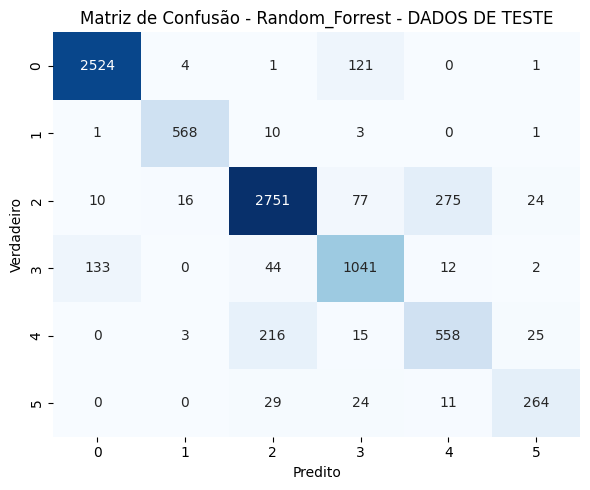

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
import nltk
from nltk.corpus import stopwords

# Baixar storpwords do NLTK
nltk.download('stopwords')

# Lista de stopwords em português
stopwords_pt = stopwords.words('portuguese')

# Criando novo pipeline
pipeline_clf_random_forest = Pipeline(steps=[
        ('feature-extraction', TfidfVectorizer()),
        ('classifier', RandomForestClassifier(
            n_jobs=-1
        ))
    ])

params_dist = {
    'feature-extraction__stop_words':[None, stopwords_pt],
    'feature-extraction__ngram_range':[(1, 1), (2, 2), (3, 3)],
    'feature-extraction__max_features':[128, 256, 512, 1024],
    'classifier__n_estimators':[25, 50, 75, 100],
    'classifier__min_samples_split': [0.001, 0.005, 0.01, 0.02, 0.05],
    'classifier__class_weight':['balanced', None]
}

#search = RandomizedSearchCV(
#    pipeline_clf_random_forest, 
#    param_distributions=params_dist,
#    n_iter=30,
#    cv=5,
#    scoring='f1_macro',
#    n_jobs=-1,
#    verbose=3
#)

# Configura o MLFlow para usar armazenamento local
mlflow.set_tracking_uri('file:///home/esdras-daniel/Documentos/Python/PGM-DataAnalysis/mlruns') 
EXPERIMENT_ID = mlflow.get_experiment_by_name('classificacao_setor_destino').experiment_id

run_experiment(pipeline_clf_random_forest,
               model_name='Random_Forrest',
               param_dist=params_dist,
               experiment_id=EXPERIMENT_ID,
               X_train=X_train,
               X_test=X_test,
               y_train=y_train,
               y_test=y_test)

In [32]:
y_pred = search.predict(X_train)
print(classification_report(y_true=y_train, y_pred=y_pred))

                                          precision    recall  f1-score   support

                            Apoio Fiscal       0.98      1.00      0.99     10604
Departamento de Cálculos e Contabilidade       0.98      0.99      0.98      2329
             Procuradoria Administrativa       0.95      0.98      0.96     12611
                     Procuradoria Fiscal       0.97      0.95      0.96      4927
                   Procuradoria Judicial       0.96      0.83      0.89      3269
                   Procuradoria da Saúde       0.99      0.93      0.96      1312

                                accuracy                           0.97     35052
                               macro avg       0.97      0.95      0.96     35052
                            weighted avg       0.97      0.97      0.97     35052



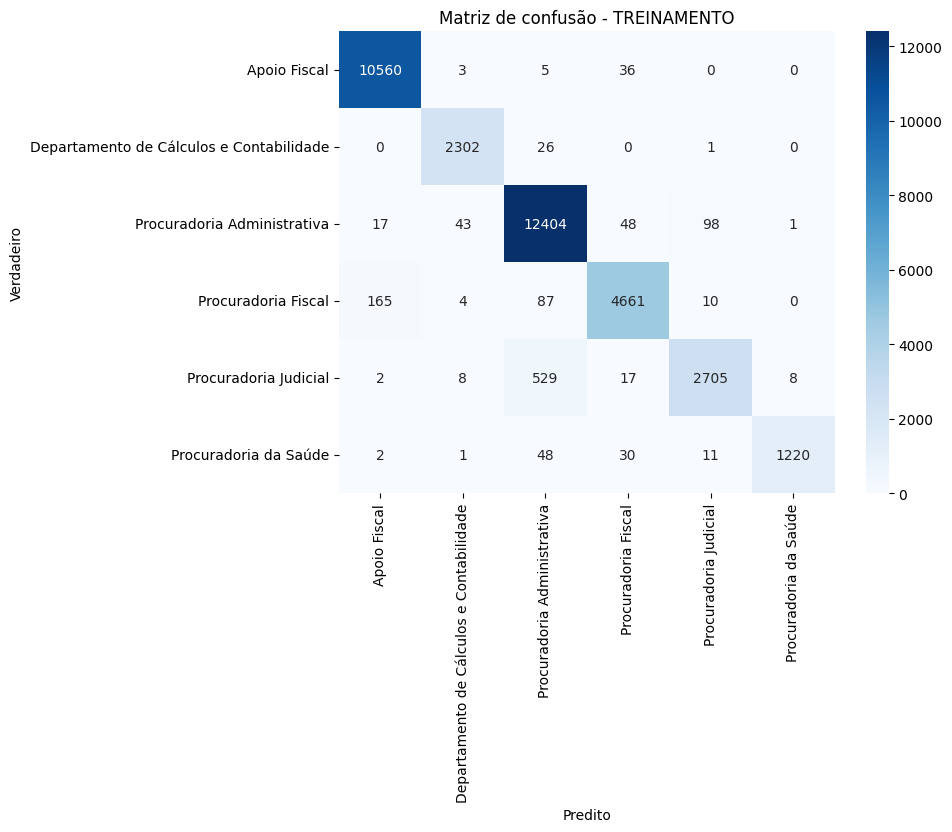

In [33]:
plot_confusion_matrix(y_true=y_train, y_pred=y_pred, title='Matriz de confusão - TREINAMENTO')

In [26]:
y_pred = search.predict(X_test)
print(classification_report(y_true=y_test, y_pred=y_pred))

                                          precision    recall  f1-score   support

                            Apoio Fiscal       0.94      0.97      0.95      2651
Departamento de Cálculos e Contabilidade       0.95      0.97      0.96       583
             Procuradoria Administrativa       0.86      0.95      0.90      3153
                     Procuradoria Fiscal       0.86      0.81      0.83      1232
                   Procuradoria Judicial       0.82      0.57      0.67       817
                   Procuradoria da Saúde       0.94      0.70      0.81       328

                                accuracy                           0.89      8764
                               macro avg       0.90      0.83      0.85      8764
                            weighted avg       0.89      0.89      0.89      8764



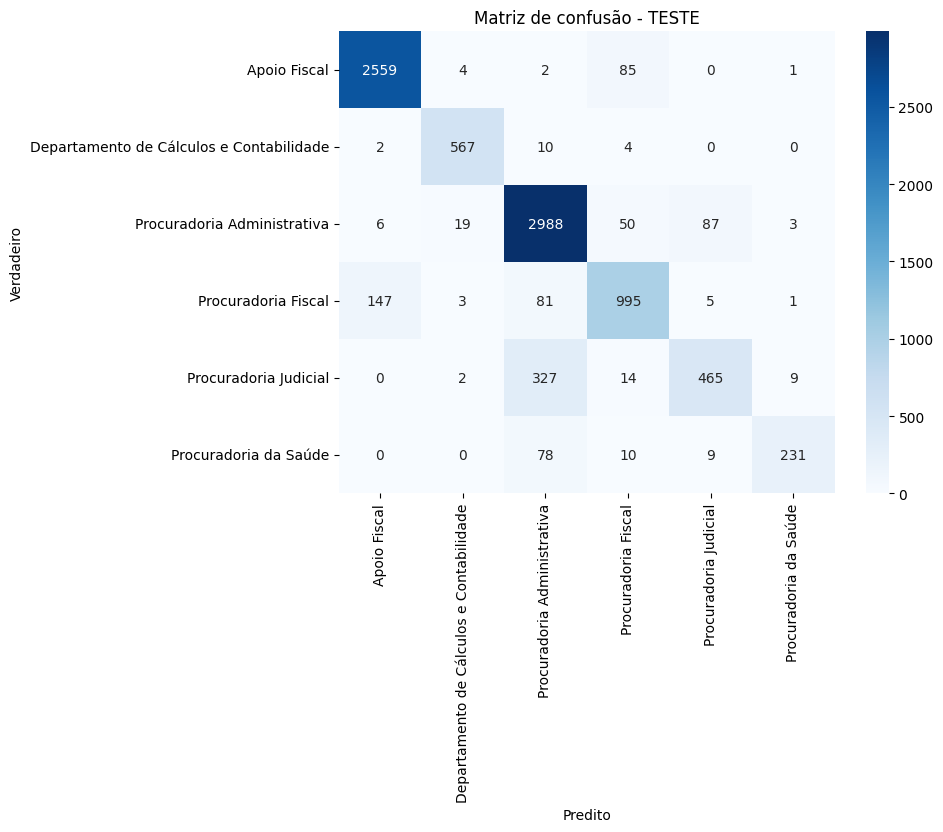

In [27]:
plot_confusion_matrix(y_true=y_test, y_pred=y_pred, title='Matriz de confusão - TESTE')

In [29]:
y_pred = search.predict(df_oot['teor_texto'])
print(classification_report(y_true=df_oot['setor_destino'], y_pred=y_pred))

                                          precision    recall  f1-score   support

                            Apoio Fiscal       0.90      0.96      0.93      1141
Departamento de Cálculos e Contabilidade       1.00      0.96      0.98       411
             Procuradoria Administrativa       0.81      0.96      0.88      1916
                     Procuradoria Fiscal       0.85      0.76      0.80       561
                   Procuradoria Judicial       0.81      0.45      0.58       631
                   Procuradoria da Saúde       0.96      0.66      0.78       209

                                accuracy                           0.86      4869
                               macro avg       0.89      0.79      0.82      4869
                            weighted avg       0.86      0.86      0.85      4869



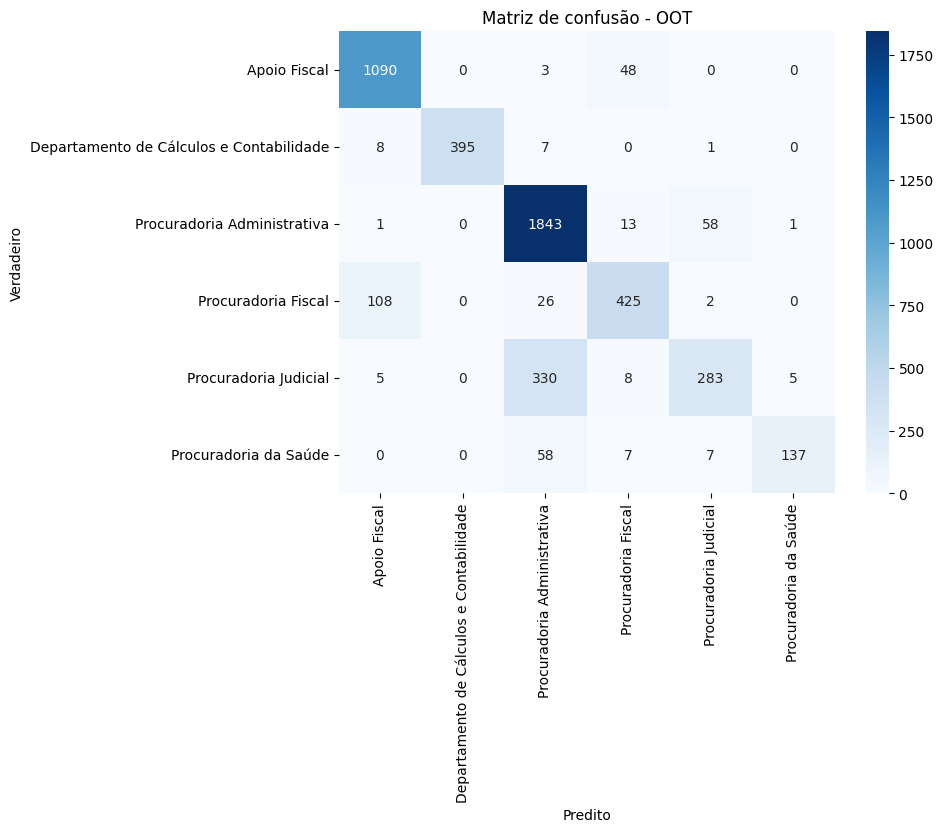

In [31]:
plot_confusion_matrix(y_true=df_oot['setor_destino'], y_pred=y_pred, title='Matriz de confusão - OOT')

# 4.2 - SVM

In [42]:
from sklearn.svm import LinearSVC

# Criando novo pipeline
pipeline_clf_v3 = Pipeline(steps=[
    ('feature-extraction', TfidfVectorizer()),
    ('classifier', LinearSVC())
])

params_dist = {
    'feature-extraction__stop_words':[None, stopwords_pt],
    'feature-extraction__ngram_range':[(1, 1), (1, 2), (1, 3)],
    'feature-extraction__max_features':[128, 256, 512, 1024],

    'classifier__C': [0.01, 0.1, 1, 10, 100],             # força de regularização
    'classifier__penalty': ['l2', 'l1'],                  # LinearSVC aceita 'l2' (l1 só com dual=False)
    'classifier__loss': ['hinge', 'squared_hinge'],       # tipos de função de perda
    'classifier__dual': [True, False],                    # escolha do modo de otimização
    'classifier__class_weight': ['balanced', None],       # tratamento de desbalanceamento
    'classifier__max_iter': [1000, 2000, 3000] 
}

randomsearchcv = RandomizedSearchCV(pipeline_clf_v3, 
                                    param_distributions=params_dist,
                                    cv=3,
                                    n_jobs=-1,
                                    verbose=5)

search = randomsearchcv.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/home/esdras-daniel/Documentos/Python/PGM-DataAnalysis/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/esdras-daniel/Documentos/Python/PGM-DataAnalysis/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/esdras-daniel/Documentos/Python/PGM-DataAnalysis/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END classifier__C=10, classifier__class_weight=None, classifier__dual=True, classifier__loss=hinge, classifier__max_iter=1000, classifier__penalty=l2, feature-extraction__max_features=128, feature-extraction__ngram_range=(1, 1), feature-extraction__stop_words=None;, score=0.834 total time=  30.4s
[CV 3/3] END classifier__C=10, classifier__class_weight=None, classifier__dual=True, classifier__loss=hinge, classifier__max_iter=1000, classifier__penalty=l2, feature-extraction__max_features=128, feature-extraction__ngram_range=(1, 1), feature-extraction__stop_words=None;, score=0.832 total time=  30.1s
[CV 1/3] END classifier__C=10, classifier__class_weight=None, classifier__dual=True, classifier__loss=hinge, classifier__max_iter=1000, classifier__penalty=l2, feature-extraction__max_features=128, feature-extraction__ngram_range=(1, 1), feature-extraction__stop_words=None;, score=0.831 total time=  32.0s
[CV 1/3] END classifier__C=0.01, classifier__class_weight=None, classifier__dua

/home/esdras-daniel/Documentos/Python/PGM-DataAnalysis/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/esdras-daniel/Documentos/Python/PGM-DataAnalysis/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/esdras-daniel/Documentos/Python/PGM-DataAnalysis/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END classifier__C=1, classifier__class_weight=None, classifier__dual=True, classifier__loss=hinge, classifier__max_iter=2000, classifier__penalty=l2, feature-extraction__max_features=512, feature-extraction__ngram_range=(1, 3), feature-extraction__stop_words=None;, score=0.863 total time= 2.2min
[CV 3/3] END classifier__C=1, classifier__class_weight=None, classifier__dual=True, classifier__loss=hinge, classifier__max_iter=2000, classifier__penalty=l2, feature-extraction__max_features=512, feature-extraction__ngram_range=(1, 3), feature-extraction__stop_words=None;, score=0.866 total time= 2.3min
[CV 1/3] END classifier__C=0.01, classifier__class_weight=None, classifier__dual=True, classifier__loss=hinge, classifier__max_iter=2000, classifier__penalty=l1, feature-extraction__max_features=1024, feature-extraction__ngram_range=(1, 2), feature-extraction__stop_words=None;, score=nan total time=  53.8s
[CV 2/3] END classifier__C=1, classifier__class_weight=None, classifier__dual=Tr

/home/esdras-daniel/Documentos/Python/PGM-DataAnalysis/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/esdras-daniel/Documentos/Python/PGM-DataAnalysis/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/esdras-daniel/Documentos/Python/PGM-DataAnalysis/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END classifier__C=1, classifier__class_weight=None, classifier__dual=False, classifier__loss=squared_hinge, classifier__max_iter=2000, classifier__penalty=l1, feature-extraction__max_features=256, feature-extraction__ngram_range=(1, 2), feature-extraction__stop_words=None;, score=0.857 total time= 3.7min
[CV 2/3] END classifier__C=1, classifier__class_weight=None, classifier__dual=False, classifier__loss=squared_hinge, classifier__max_iter=2000, classifier__penalty=l1, feature-extraction__max_features=256, feature-extraction__ngram_range=(1, 2), feature-extraction__stop_words=None;, score=0.856 total time= 3.8min
[CV 1/3] END classifier__C=1, classifier__class_weight=None, classifier__dual=False, classifier__loss=squared_hinge, classifier__max_iter=2000, classifier__penalty=l1, feature-extraction__max_features=256, feature-extraction__ngram_range=(1, 2), feature-extraction__stop_words=None;, score=0.855 total time= 3.8min


/home/esdras-daniel/Documentos/Python/PGM-DataAnalysis/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
15 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
6 fits failed with the following error:
Traceback (most recent call last):
  File "/home/esdras-daniel/Documentos/Python/PGM-DataAnalysis/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/esdras-daniel/Documentos/Python/PGM-DataAnalysis/.venv/lib/python3.12/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^

In [44]:
y_pred = search.predict(X_train)
print(classification_report(y_true=y_train, y_pred=y_pred))

                                          precision    recall  f1-score   support

                            Apoio Fiscal       0.92      0.97      0.94     10604
Departamento de Cálculos e Contabilidade       0.96      0.98      0.97      2329
             Procuradoria Administrativa       0.83      0.95      0.89     12611
                     Procuradoria Fiscal       0.83      0.76      0.79      4927
                   Procuradoria Judicial       0.84      0.37      0.51      3269
                   Procuradoria da Saúde       0.92      0.77      0.83      1312

                                accuracy                           0.87     35052
                               macro avg       0.88      0.80      0.82     35052
                            weighted avg       0.87      0.87      0.86     35052



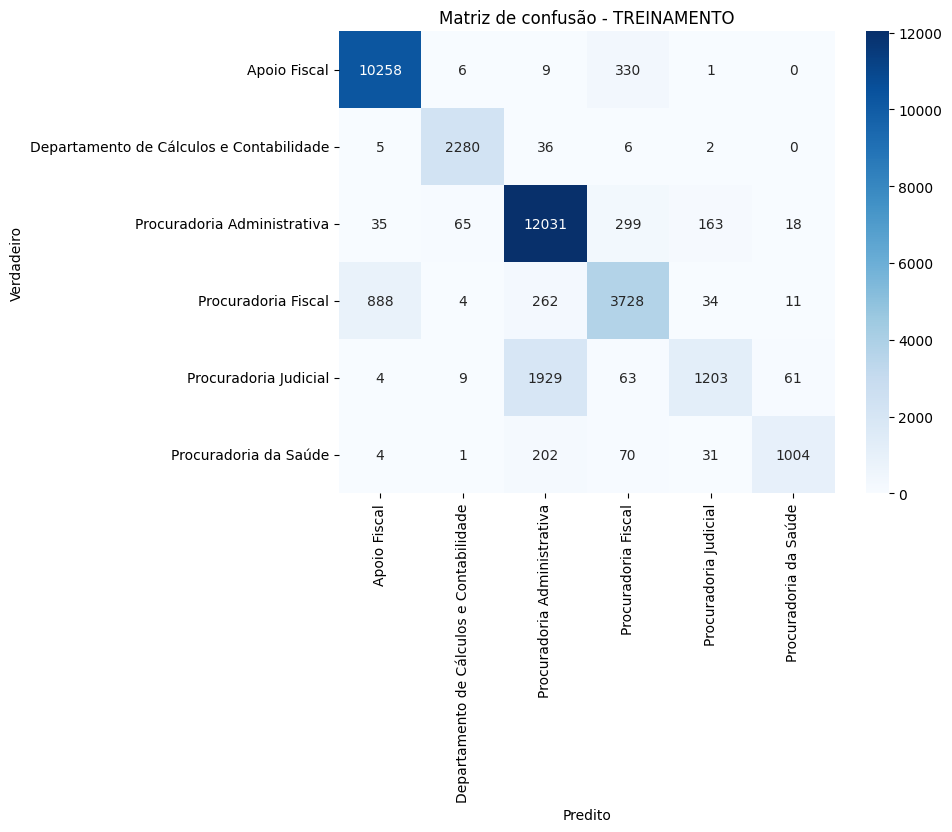

In [45]:
plot_confusion_matrix(y_true=y_train, y_pred=y_pred, title='Matriz de confusão - TREINAMENTO')

In [46]:
y_pred = search.predict(X_test)
print(classification_report(y_true=y_test, y_pred=y_pred))

                                          precision    recall  f1-score   support

                            Apoio Fiscal       0.92      0.97      0.94      2651
Departamento de Cálculos e Contabilidade       0.95      0.98      0.96       583
             Procuradoria Administrativa       0.82      0.95      0.88      3153
                     Procuradoria Fiscal       0.83      0.76      0.79      1232
                   Procuradoria Judicial       0.83      0.35      0.49       817
                   Procuradoria da Saúde       0.89      0.73      0.80       328

                                accuracy                           0.87      8764
                               macro avg       0.87      0.79      0.81      8764
                            weighted avg       0.87      0.87      0.85      8764



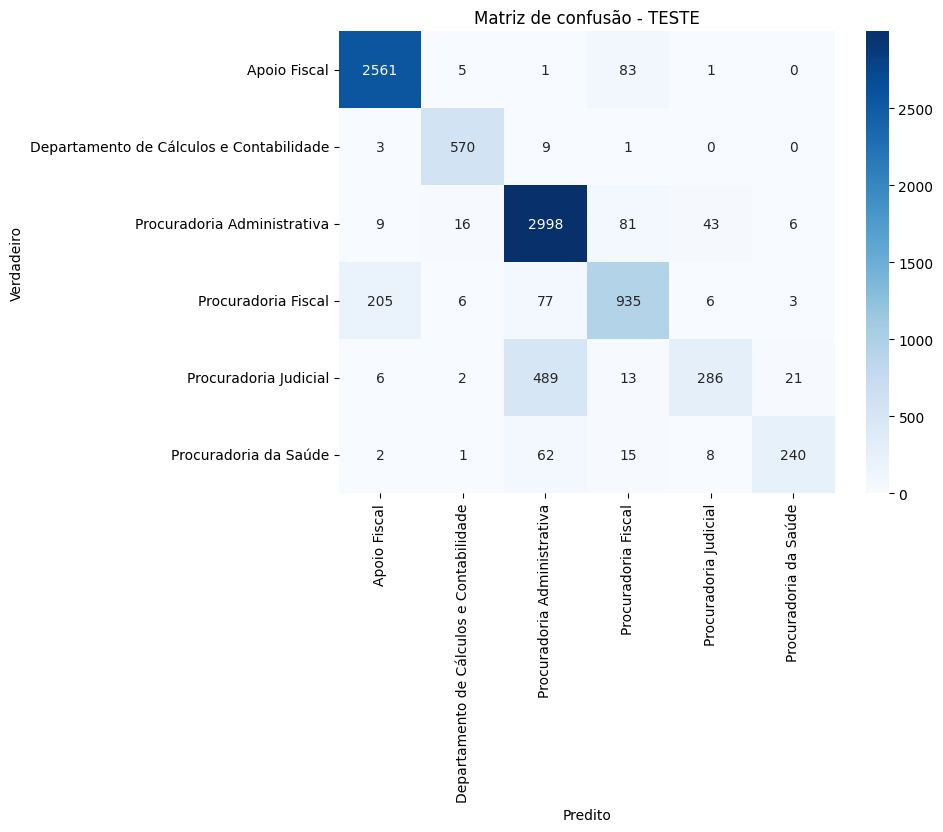

In [47]:
plot_confusion_matrix(y_true=y_test, y_pred=y_pred, title='Matriz de confusão - TESTE')

In [48]:
y_pred = search.predict(df_oot['teor_texto'])
print(classification_report(y_true=df_oot['setor_destino'], y_pred=y_pred))

                                          precision    recall  f1-score   support

                            Apoio Fiscal       0.89      0.97      0.93      1141
Departamento de Cálculos e Contabilidade       1.00      0.96      0.98       411
             Procuradoria Administrativa       0.80      0.97      0.88      1916
                     Procuradoria Fiscal       0.85      0.73      0.79       561
                   Procuradoria Judicial       0.82      0.37      0.51       631
                   Procuradoria da Saúde       0.92      0.70      0.80       209

                                accuracy                           0.85      4869
                               macro avg       0.88      0.78      0.81      4869
                            weighted avg       0.85      0.85      0.84      4869



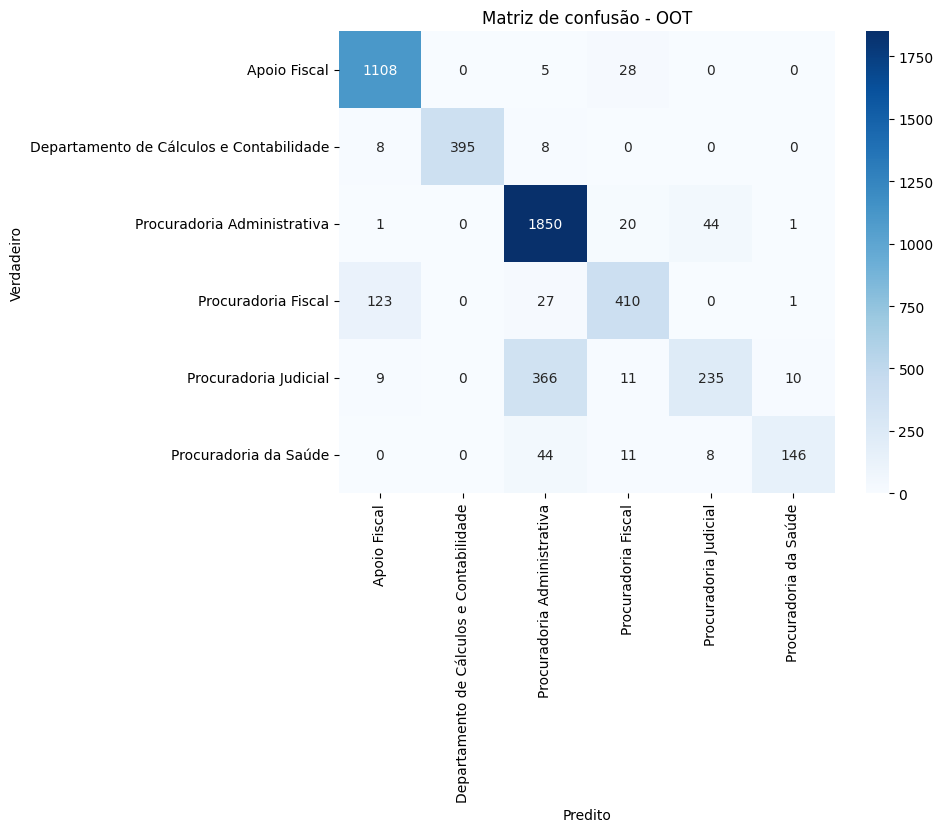

In [49]:
plot_confusion_matrix(y_true=df_oot['setor_destino'], y_pred=y_pred, title='Matriz de confusão - OOT')

## 4.3 - Logistic Regression

In [50]:
from sklearn.linear_model import LogisticRegression

# Criando novo pipeline
pipeline_clf_v4 = Pipeline(steps=[
    ('feature-extraction', TfidfVectorizer()),
    ('classifier', LogisticRegression())
])

params_dist = {
    'feature-extraction__stop_words':[None, stopwords_pt],
    'feature-extraction__ngram_range':[(1, 1), (1, 2), (1, 3)],
    'feature-extraction__max_features':[128, 256, 512, 1024],

    'classifier__penalty': ['l1', 'l2'],                        # tipos de penalização
    'classifier__C': [0.01, 0.1, 1, 10, 100],                   # força de regularização
    #'classifier__solver': ['liblinear', 'saga'],                # solvers compatíveis com l1 e elasticnet
    'classifier__class_weight': ['balanced', None],             # lidar com desbalanceamento
    'classifier__max_iter': [100, 500, 1000, 5000]              # iterações máximas
}

randomsearchcv = RandomizedSearchCV(pipeline_clf_v4, 
                                    param_distributions=params_dist,
                                    cv=3,
                                    n_jobs=-1,
                                    verbose=5)

search = randomsearchcv.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 2/3] END classifier__C=0.01, classifier__class_weight=None, classifier__max_iter=5000, classifier__penalty=l2, feature-extraction__max_features=256, feature-extraction__ngram_range=(1, 1), feature-extraction__stop_words=None;, score=0.691 total time=  24.2s
[CV 1/3] END classifier__C=0.01, classifier__class_weight=None, classifier__max_iter=5000, classifier__penalty=l2, feature-extraction__max_features=256, feature-extraction__ngram_range=(1, 1), feature-extraction__stop_words=None;, score=0.691 total time=  25.4s
[CV 3/3] END classifier__C=0.01, classifier__class_weight=None, classifier__max_iter=5000, classifier__penalty=l2, feature-extraction__max_features=256, feature-extraction__ngram_range=(1, 1), feature-extraction__stop_words=None;, score=0.690 total time=  25.1s
[CV 1/3] END classifier__C=1, classifier__class_weight=None, classifier__max_iter=5000, classifier__penalty=l1, feature-extraction__max_features=128, fea

/home/esdras-daniel/Documentos/Python/PGM-DataAnalysis/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/esdras-daniel/Documentos/Python/PGM-DataAnalysis/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

[CV 3/3] END classifier__C=1, classifier__class_weight=balanced, classifier__max_iter=100, classifier__penalty=l2, feature-extraction__max_features=256, feature-extraction__ngram_range=(1, 2), feature-extraction__stop_words=None;, score=0.794 total time= 1.1min
[CV 1/3] END classifier__C=1, classifier__class_weight=balanced, classifier__max_iter=100, classifier__penalty=l2, feature-extraction__max_features=256, feature-extraction__ngram_range=(1, 2), feature-extraction__stop_words=None;, score=0.799 total time= 1.2min
[CV 2/3] END classifier__C=1, classifier__class_weight=balanced, classifier__max_iter=100, classifier__penalty=l2, feature-extraction__max_features=256, feature-extraction__ngram_range=(1, 2), feature-extraction__stop_words=None;, score=0.793 total time= 1.2min
[CV 3/3] END classifier__C=10, classifier__class_weight=balanced, classifier__max_iter=100, classifier__penalty=l1, feature-extraction__max_features=128, feature-extraction__ngram_range=(1, 3), feature-extraction__

/home/esdras-daniel/Documentos/Python/PGM-DataAnalysis/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
15 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/home/esdras-daniel/Documentos/Python/PGM-DataAnalysis/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/esdras-daniel/Documentos/Python/PGM-DataAnalysis/.venv/lib/python3.12/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^

In [51]:
y_pred = search.predict(X_train)
print(classification_report(y_true=y_train, y_pred=y_pred))

                                          precision    recall  f1-score   support

                            Apoio Fiscal       0.88      0.97      0.92     10604
Departamento de Cálculos e Contabilidade       0.96      0.96      0.96      2329
             Procuradoria Administrativa       0.80      0.96      0.87     12611
                     Procuradoria Fiscal       0.81      0.64      0.72      4927
                   Procuradoria Judicial       0.87      0.28      0.43      3269
                   Procuradoria da Saúde       0.92      0.69      0.79      1312

                                accuracy                           0.84     35052
                               macro avg       0.87      0.75      0.78     35052
                            weighted avg       0.85      0.84      0.83     35052



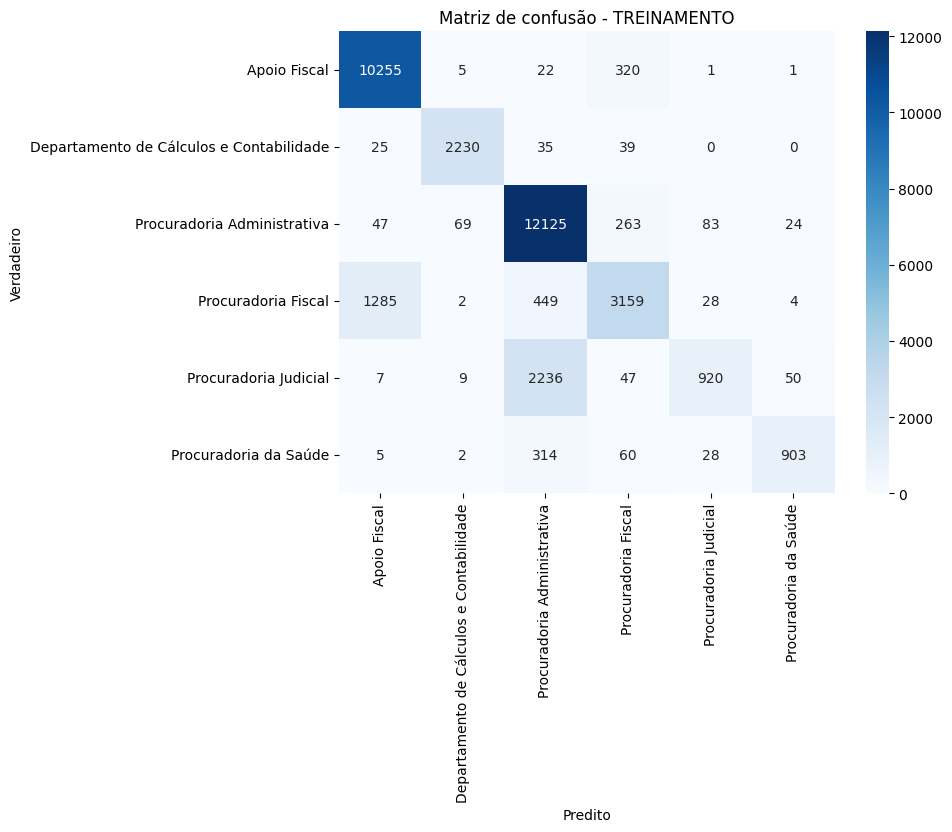

In [52]:
plot_confusion_matrix(y_true=y_train, y_pred=y_pred, title='Matriz de confusão - TREINAMENTO')

In [53]:
y_pred = search.predict(X_test)
print(classification_report(y_true=y_test, y_pred=y_pred))

                                          precision    recall  f1-score   support

                            Apoio Fiscal       0.89      0.97      0.93      2651
Departamento de Cálculos e Contabilidade       0.96      0.96      0.96       583
             Procuradoria Administrativa       0.79      0.97      0.87      3153
                     Procuradoria Fiscal       0.83      0.66      0.73      1232
                   Procuradoria Judicial       0.86      0.25      0.39       817
                   Procuradoria da Saúde       0.92      0.65      0.76       328

                                accuracy                           0.85      8764
                               macro avg       0.88      0.74      0.77      8764
                            weighted avg       0.85      0.85      0.83      8764



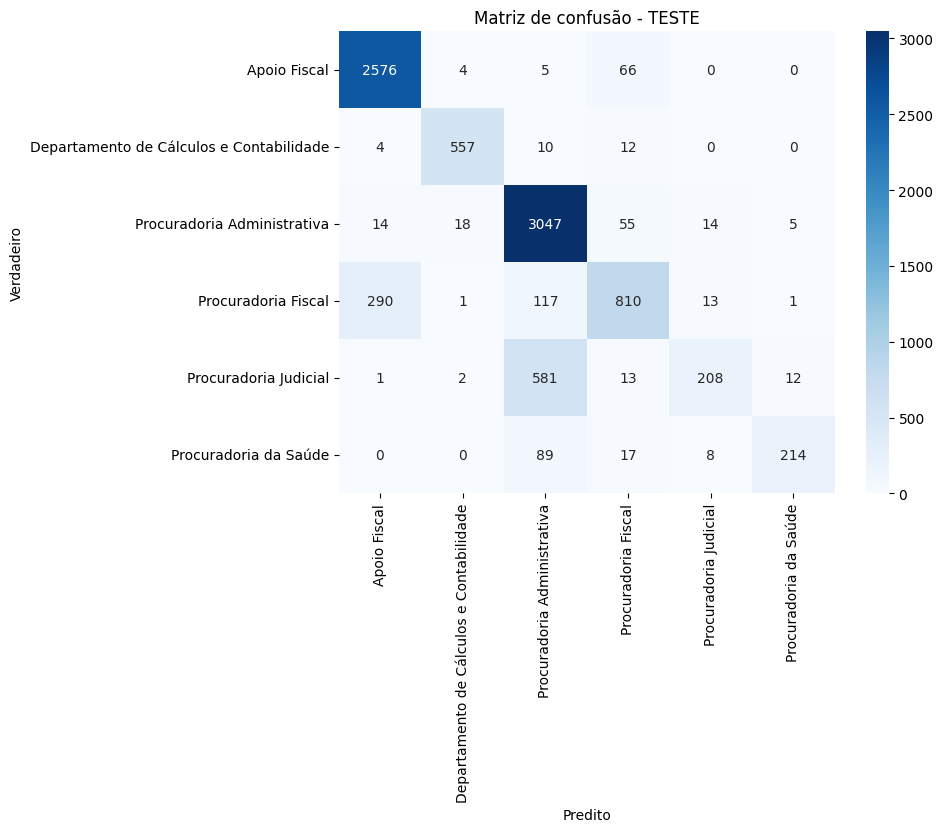

In [54]:
plot_confusion_matrix(y_true=y_test, y_pred=y_pred, title='Matriz de confusão - TESTE')

In [55]:
y_pred = search.predict(df_oot['teor_texto'])
print(classification_report(y_true=df_oot['setor_destino'], y_pred=y_pred))

                                          precision    recall  f1-score   support

                            Apoio Fiscal       0.83      0.97      0.89      1141
Departamento de Cálculos e Contabilidade       1.00      0.96      0.98       411
             Procuradoria Administrativa       0.77      0.95      0.85      1916
                     Procuradoria Fiscal       0.83      0.57      0.67       561
                   Procuradoria Judicial       0.79      0.31      0.45       631
                   Procuradoria da Saúde       0.93      0.66      0.77       209

                                accuracy                           0.82      4869
                               macro avg       0.86      0.74      0.77      4869
                            weighted avg       0.82      0.82      0.80      4869



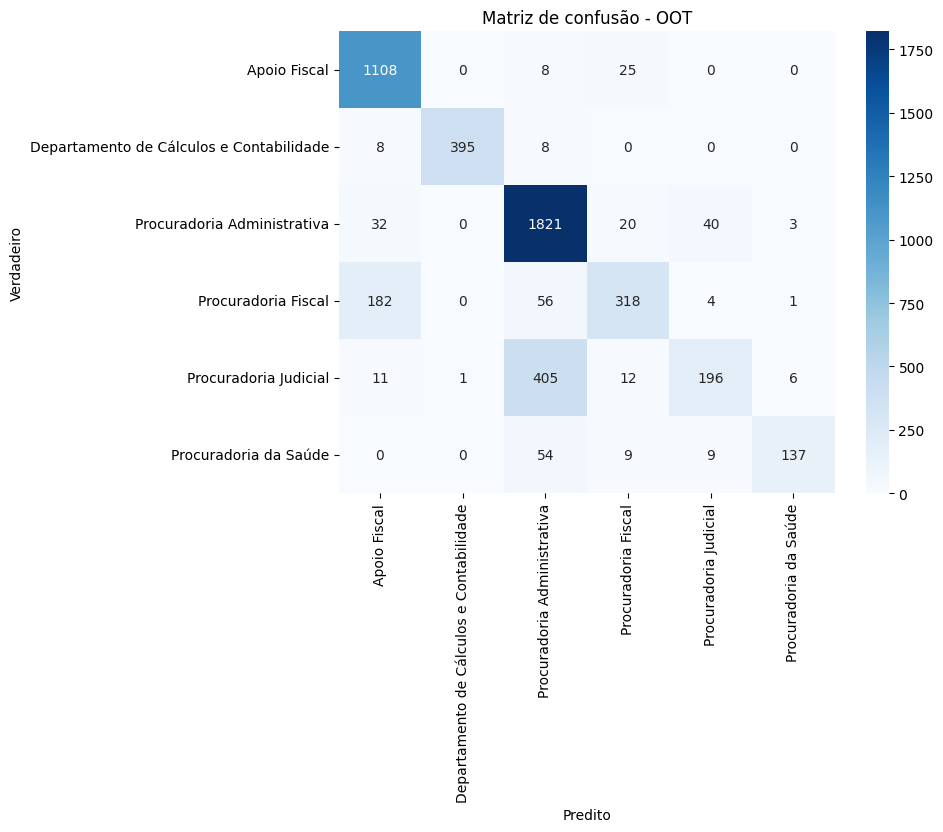

In [56]:
plot_confusion_matrix(y_true=df_oot['setor_destino'], y_pred=y_pred, title='Matriz de confusão - OOT')

| Classe                                       | RF Precision | RF Recall | RF F1  | SVM Precision | SVM Recall | SVM F1 | LR Precision | LR Recall | LR F1 |
|----------------------------------------------|--------------|-----------|--------|---------------|------------|--------|--------------|-----------|-------|
| Apoio Fiscal                                 | 0.94         | 0.97      | 0.95   | 0.92          | 0.97       | 0.94   | 0.89         | 0.97      | 0.93  |
| Departamento de Cálculos e Contabilidade     | 0.95         | 0.97      | 0.96   | 0.95          | 0.98       | 0.96   | 0.96         | 0.96      | 0.96  |
| Procuradoria Administrativa                  | 0.86         | 0.95      | 0.90   | 0.82          | 0.95       | 0.88   | 0.79         | 0.97      | 0.87  |
| Procuradoria Fiscal                          | 0.86         | 0.81      | 0.83   | 0.83          | 0.76       | 0.79   | 0.83         | 0.66      | 0.73  |
| Procuradoria Judicial                        | 0.82         | 0.57      | 0.67   | 0.83          | 0.35       | 0.49   | 0.86         | 0.25      | 0.39  |
| Procuradoria da Saúde                        | 0.94         | 0.70      | 0.81   | 0.89          | 0.73       | 0.80   | 0.92         | 0.65      | 0.76  |
| **Acurácia**                                 | **0.89**     | —         | —      | **0.87**      | —          | —      | **0.85**     | —         | —     |
| **Média Macro**                              | 0.90         | 0.83      | 0.85   | 0.87          | 0.79       | 0.81   | 0.88         | 0.74      | 0.77  |
| **Média Ponderada**                          | 0.89         | 0.89      | 0.89   | 0.87          | 0.87       | 0.85   | 0.85         | 0.85      | 0.83  |
